In [ ]:
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
!unzip '/content/Data.zip'
!unzip '/content/img.zip'

In [28]:
def get_relevant_indices(dataset, classes, target_classes):
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

In [33]:
#path to data folders on Google Drive
main_path = '/content/'
transform = transforms.Compose([transforms.Resize((224)),
                                transforms.Grayscale(),
                                transforms.ToTensor()])

#Target: 60% train, 20% validation, 20% test samples
data_folder = torchvision.datasets.ImageFolder(main_path + 'Data', transform = transform)
classes = ['Correct', 'Incorrect']
relevant_indices = get_relevant_indices(data_folder, classes, classes)
np.random.seed(1000)
np.random.shuffle(relevant_indices)
split1 = int(len(relevant_indices)* 0.2) # 20% test set
split2 = int(len(relevant_indices)* 0.4) # 20% validation set, remaining 60% is training set
test_ind, val_ind, train_ind = relevant_indices[:split1], relevant_indices[split1:split2], relevant_indices[split2:]

test_sampler = SubsetRandomSampler(test_ind)
test_loader = torch.utils.data.DataLoader(data_folder, batch_size=40,
                                               num_workers=1, sampler=test_sampler)
val_sampler = SubsetRandomSampler(val_ind)
val_loader = torch.utils.data.DataLoader(data_folder, batch_size=40,
                                               num_workers=1, sampler=val_sampler)
train_sampler = SubsetRandomSampler(train_ind)
train_loader = torch.utils.data.DataLoader(data_folder, batch_size=40,
                                               num_workers=1, sampler=train_sampler)
print(len(test_ind), len(val_ind), len(train_ind))


378 378 1136


In [34]:
torch.manual_seed(10) # set the random seed
from math import floor

class CNNClassifier(nn.Module):
    def __init__(self, kernel_sizes = [10, 5, 3], name = "CNN_Classifier"):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_sizes[0])
        self.conv2 = nn.Conv2d(5, 10, kernel_sizes[1])
        self.conv3 = nn.Conv2d(10, 25, kernel_sizes[2])

        self.pool = nn.MaxPool2d(2, 2)

        # Computing the correct input size into the Fully Connected Layer
        self.x = floor((224 - kernel_sizes[0] + 1)/2)
        self.y = floor((self.x - kernel_sizes[1] + 1)/2)
        self.z = floor((self.y - kernel_sizes[2] + 1)/2)
        self.FC_input = 25*self.z*self.z

        self.fc1 = nn.Linear(self.FC_input, 32)
        self.fc2 = nn.Linear(32, 2)

        self.name = name        

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.FC_input)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [36]:
def get_model_path(name, batch_size, lr, epoch):
    path = "name_{}_size{}_lr{}_epoch{}".format(name, batch_size, lr, epoch)
    return path
def train(model, train_loader, val_loader, batch_size, num_epochs, learn_rate):
    torch.manual_seed(10)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

  
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    # training
    print ("Training Started...")
    n = 0
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_images = 0
        for imgs, labels in iter(train_loader):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1          
        
        # track accuracy
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)

        print(("Epoch {}: Train acc: {} |" + "Validation acc: {}").format(epoch, train_acc[epoch], val_acc[epoch]))

        model_path = get_model_path(model.name, batch_size, learn_rate, epoch)
        torch.save(model.state_dict(), model_path)
            
    epochs = np.arange(1, num_epochs + 1)
   
    
    return train_acc, val_acc, epochs
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Training Started...
Epoch 0: Train acc: 0.9022887323943662 |Validation acc: 0.9047619047619048
Epoch 1: Train acc: 0.9330985915492958 |Validation acc: 0.9126984126984127
Epoch 2: Train acc: 0.7658450704225352 |Validation acc: 0.708994708994709
Epoch 3: Train acc: 0.9586267605633803 |Validation acc: 0.9365079365079365
Epoch 4: Train acc: 0.9859154929577465 |Validation acc: 0.9576719576719577
Epoch 5: Train acc: 0.9911971830985915 |Validation acc: 0.9470899470899471
Epoch 6: Train acc: 0.9955985915492958 |Validation acc: 0.9576719576719577
Epoch 7: Train acc: 0.988556338028169 |Validation acc: 0.9603174603174603
Epoch 8: Train acc: 0.9727112676056338 |Validation acc: 0.9285714285714286
Epoch 9: Train acc: 0.9982394366197183 |Validation acc: 0.9629629629629629
Epoch 10: Train acc: 1.0 |Validation acc: 0.9656084656084656
Epoch 11: Train acc: 1.0 |Validation acc: 0.9629629629629629
Epoch 12: Train acc: 1.0 |Validation acc: 0.9603174603174603
Epoch 13: Train acc: 0.9991197183098591 |Validati

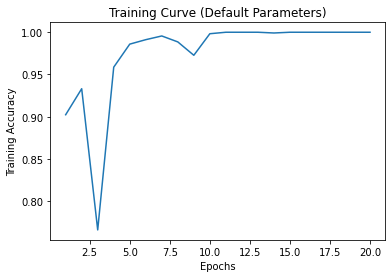

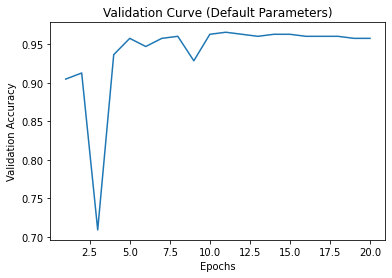

In [37]:
CNN = CNNClassifier()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  CNN.cuda()

train_acc, val_acc, epochs = train(CNN, train_loader, val_loader, batch_size= 128, num_epochs= 20, learn_rate= 0.0015)

plt.plot(epochs, train_acc)
plt.title("Training Curve (Default Parameters)")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(epochs, val_acc)
plt.title("Validation Curve (Default Parameters)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

In [38]:
model_path = get_model_path(CNN.name, batch_size=128, lr=0.0015, epoch=7-1)
state = torch.load(model_path)
CNN.load_state_dict(state)
get_accuracy(CNN, test_loader)

0.955026455026455

In [39]:
transform_2 = transforms.Compose([transforms.Resize((224,224)),
                                transforms.Grayscale(),
                                transforms.ToTensor()])
data_folder2 = torchvision.datasets.ImageFolder(main_path + 'img', transform = transform_2)
relevant_indices = get_relevant_indices(data_folder2, classes, classes)
np.random.seed(1000)
np.random.shuffle(relevant_indices)
test_ind_2= relevant_indices[len(relevant_indices)-1]

test_sampler_2 = SubsetRandomSampler(test_ind_2)

test_loader_2 = torch.utils.data.DataLoader(data_folder2, batch_size=20)

In [40]:
get_accuracy(CNN, test_loader_2)

0.75